<h1>Validate the Elevation Method against the 4.5 m AWAC</h1>

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import glob
from matplotlib.animation import FuncAnimation
import pickle
%matplotlib widget

In [73]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.accel_nan_inds = accel_nans
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

<h2>Make a subset of all data between 4-5 meters to validate method against the </h2>

In [74]:
# Data from 4.5 meter AWAC
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))

In [75]:
def computeEta(t, accel_z, fs, low_freq_cutoff=None, high_freq_cutoff=None, order=None):
    # Define the filter if not given
    if low_freq_cutoff is None:
        low_freq_cutoff = 0.05
        high_freq_cutoff = 2
        order = 1
       
    # Define the filter
    b, a = signal.butter(order, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=fs)

    # Zero pad the edges to reduce edge effects
    pad_size = 500
    a_z_padded = np.zeros(accel_z.size + pad_size*2)
    a_z_padded[pad_size:-pad_size] = accel_z

    # Filter and integrate to velocity and position
    a_z = signal.filtfilt(b, a, a_z_padded)
    w_nofilt = integrate.cumulative_trapezoid(a_z, dx=1/fs, initial=0)
    w = signal.filtfilt(b, a, w_nofilt)
    z_nofilt = integrate.cumulative_trapezoid(w, dx=1/fs, initial=0)
    z = signal.filtfilt(b, a, z_nofilt)

    # Remove the edges of the time series due to the edge effects of filtering
    edge_removed = 100
    t = t[edge_removed : -edge_removed]
    a_z = a_z[pad_size + edge_removed : -(pad_size + edge_removed)]
    w = w[pad_size + edge_removed : -(pad_size + edge_removed)]
    z = z[pad_size + edge_removed : -(pad_size + edge_removed)]

    return t, a_z, w, z

def computeSpectra(z, fs):
    # Remove sections that are mostly zeros
    

    nperseg = 3600
    overlap = 0.75
    f, E = signal.welch(z, fs=fs, window='hann', nperseg=nperseg, noverlap=np.floor(nperseg*overlap))
    return f, E

def bandAvgE(f, E, points_to_average):
    '''
    @ejrainville

    Split an array into sized chunks then average each chunk 
    '''
    num_sections = E.size // points_to_average
    f_chunks = np.array_split(f, num_sections)
    E_chunks = np.array_split(E, num_sections)
    f_bandavg = np.array([np.mean(chunk) for chunk in f_chunks ])
    E_bandavg = np.array([np.mean(chunk) for chunk in E_chunks ])
    return f_bandavg, E_bandavg

def processZAccel(t, accel_z, fs, low_freq_cutoff=None, high_freq_cutoff=None, order=None):
    t, a_z, w, z = computeEta(t, accel_z, fs, low_freq_cutoff, high_freq_cutoff, order)

    # Compute the spectra
    f, E = computeSpectra(z, fs)
    
    # Band Average the spectra  
    points_to_average = 5
    f_bandavg, E_bandavg = bandAvgE(f, E, points_to_average)

    return t, a_z, w, z, f, E, f_bandavg, E_bandavg

In [76]:
# Functionalize finding the bathymetry to make it easy to call multiple times
def bathyAlongTrack(bathy_f, microSWIFT_of_interest):
    '''
    @ejrainville

    Linearly interpolates the bathymetry along the track of the microSWIFT.

    Parameters: bathy_f: interpolation class
                         an interpolation class set up by the bathymetry grid that takes in inputs of x and y location in the FRF coordinates and outputs the elevation 

                microSWIFT_of_interest: a microSWIFT class structure

    Returns: bathy_along_track: numpy array
                                An array of the interpolated bathymetry along the track of the microSWIFT

    '''
    bathy_along_track = []
    for n in np.arange(microSWIFT_of_interest.x.size):
        bathy_along_track.append(np.squeeze(bathy_f(microSWIFT_of_interest.x[n], microSWIFT_of_interest.y[n])).item())
    
    return bathy_along_track

def consecutive(data, stepsize=1):
    arrays = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    size = 0
    ind_of_max = 0
    for n in np.arange(len(arrays)):
        if len(arrays[n]) > size:
            size = len(arrays[n])
            ind_of_max = n

    # Largest array
    largest_array = arrays[ind_of_max]
    return largest_array

def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin(0)

In [77]:
# Make a near AWAC structure 
class nearAWACData:
    def __init__(self, time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_num, mission_num):
        '''
        @ ejrainville

        Initialize a data strucuture to store the data from each microSWIFT near the AWAC
        '''
        # Set all the input variables as variables in the structure
        self.time = time_near_awac
        self.bathy = bathy_near_awac
        self.a_x = accel_x
        self.a_y = accel_y
        self.a_z = accel_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.x = x
        self.y = y
        self.u = u
        self.v = v
        self.microSWIFT_num = microSWIFT_num
        self.mission_num = mission_num

def nearAWACDict( time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_num, mission_num):
    data_dict = {'time':time_near_awac, 'microSWIFT_num':microSWIFT_num, 'mission_num':mission_num, 'bathy':bathy_near_awac, 'a_x':accel_x, 'a_y':accel_y, 'a_z':accel_z, 'gyro_x':gyro_x, 'gyro_y':gyro_y, 'gyro_z':gyro_z, 'mag_x':mag_x, 'mag_y':mag_y, 'mag_z':mag_z, 'x':x, 'y':y, 'u':u, 'v':v}
    return data_dict


In [78]:
# # Data between 4-5 m subset
# # Make a list of all missions
# mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
# mission_list_subset = mission_list

# # Bathymetry DEM
# bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
# elevation_dem = bathy_data['elevation'][0,:,:]
# bathy_xFRF = bathy_data['xFRF'][:]
# bathy_yFRF = bathy_data['yFRF'][:]
# bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, elevation_dem)

# # AWAC Data
# awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
# awac_time = cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)

# # Loop through all missions to look at each microSWIFT
# nearAWAC_list = []
# nearAWACDataDict_list = []
# for mission in mission_list_subset:
#     # Make a dataset of the mission 
#     mission_dataset = nc.Dataset(mission)

#     # Make list of all micros in the mission
#     microSWIFTs_on_mission = list(mission_dataset.groups.keys())

#     # Loop through every microSWIFT in the mission
#     for microSWIFT_of_interest_str in microSWIFTs_on_mission:
#         microSWIFT_of_interest = microSWIFT(mission_dataset, microSWIFT_num=microSWIFT_of_interest_str)

#         # Interpolate the Bathymetry grid along the microSWIFT track
#         bathy_along_track = bathyAlongTrack(bathy_f, microSWIFT_of_interest)
#         # Find all times when bathymetry is between 4 - 5 meters depth 
#         inds_in_set = np.where((np.abs(bathy_along_track) > 4) & (np.abs(bathy_along_track) < 5))[0]

#         # Find only consecutive values
#         inds = consecutive(inds_in_set)

#         # NOTE: usign 7400 points isntead of 7200 since 200 points are removed due to filtering 
#         if len(inds) > 7400:
#             # Get all variables for this subdataset
#             time_near_awac = np.array([microSWIFT_of_interest.time_datetime[i] for i in inds])
#             bathy_near_awac = np.array([bathy_along_track[i] for i in inds])
#             accel_x = np.array([microSWIFT_of_interest.ax_body[i] for i in inds])
#             accel_y = np.array([microSWIFT_of_interest.ay_body[i] for i in inds])
#             accel_z = np.array([microSWIFT_of_interest.az_body[i] for i in inds])
#             gyro_x = np.array([microSWIFT_of_interest.gyro_x[i] for i in inds])
#             gyro_y = np.array([microSWIFT_of_interest.gyro_y[i] for i in inds])
#             gyro_z = np.array([microSWIFT_of_interest.gyro_z[i] for i in inds])
#             mag_x = np.array([microSWIFT_of_interest.mag_x[i] for i in inds])
#             mag_y = np.array([microSWIFT_of_interest.mag_y[i] for i in inds])
#             mag_z = np.array([microSWIFT_of_interest.mag_z[i] for i in inds])
#             x = np.array([microSWIFT_of_interest.x[i] for i in inds])
#             y = np.array([microSWIFT_of_interest.y[i] for i in inds])
#             u = np.array([microSWIFT_of_interest.u[i] for i in inds])
#             v = np.array([microSWIFT_of_interest.v[i] for i in inds])

#            # Save this data into a nearAWACData strucuture and append to nearAWAC list
#             nearAWAC_list.append(nearAWACData(time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_of_interest_str, mission))
#             nearAWACDataDict_list.append(nearAWACDict( time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_of_interest_str, mission))

#         else:
#             continue
# # Pickle the nearAWAC dataset so it is easily loaded back in 
# pik = 'nearAWAC_data.dat'
# with open(pik, "wb") as f:
#     pickle.dump(nearAWAC_list, f)



In [79]:
# # Remove Datasets that have large gaps in them for analysis now
# datasets_to_save = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 20, 21]

# # Save the data dictionaries as mat files
# for subset_num in datasets_to_save:
#     subset = nearAWACDataDict_list[subset_num]
#     io.savemat('nearAWACData_mission{}_{}.mat'.format(subset['mission_num'][-5:-3], subset['microSWIFT_num']), subset)

In [80]:
# Load in the pickled nearAWAC data
pik = 'nearAWAC_data.dat'
with open(pik, "rb") as f:
    nearAWAC_data = pickle.load(f)

<h2>Lets turn this into an optimization problem - optimize the filter to minimize error across all subsets of data</h2>

0
1
2
3
4
5
6
7
8
20
21


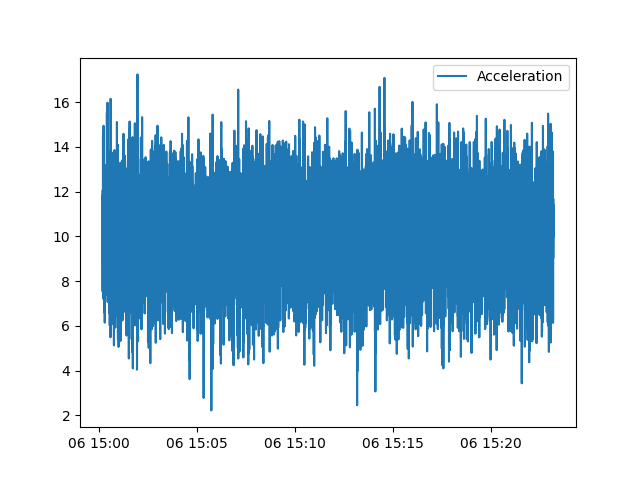

In [81]:
# Look through list and remove any time series that have flat sections due to iterpolation
n = 11
fig_ts, ax = plt.subplots()
ax.plot(nearAWAC_data[n].time, nearAWAC_data[n].a_z, label='Acceleration')
ax.legend()

# Define list of datasets that are ok
# not including 10, 12, 13, 14, 15, 16, 17, 18, 19
datasets_to_analyze = [0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 21]
nearAWAC_data_subset = []
for val in datasets_to_analyze:
    print(val)
    nearAWAC_data_subset.append(nearAWAC_data[val])

In [82]:
# optimize the filter inputs to minimize the mean square error of the ratio between the AWAC and micro spectra and the 
def optimizeBandPassFilter(filter_values, nearAWAC_data, awac_time, awac_data):
    # Compute eta from this time series
    fs = 12
    low_freq_cutoff = filter_values[0]
    high_freq_cutoff = filter_values[1]
    order = int(filter_values[2])

    E_ratio_avg = np.empty(27)
    num_datasets = len(nearAWAC_data)
    for nearAWACDatasets in nearAWAC_data:
        # Process the acceleration data
        t, a_z, w, z, f, E, f_bandavg, E_bandavg = processZAccel(nearAWACDatasets.time, nearAWACDatasets.a_z, fs, low_freq_cutoff, high_freq_cutoff, order)
        
        # Subset the frequency and Energy Density to compare the values
        f_inds = np.where((f_bandavg > 0.05) & (f_bandavg < 0.5))[0]
        f_waves = np.array([f_bandavg[i] for i in f_inds])
        E_waves = np.array([E_bandavg[i] for i in f_inds])

        # Find the 4.5 m AWAC spectrum closest to the time of this spectrum 
        time_index = nearest_ind(awac_time, t[0])
        f_awac = awac_data['waveFrequency'][:]
        E_awac = awac_data['waveEnergyDensity'][time_index,:]
        E_awac_interp = np.interp(f_waves, f_awac, E_awac)

        # Compute the ratio of the AWAC and Micro Energy Density 
        E_ratio = E_waves / E_awac_interp

        # Add E_ratio to compute the average
        E_ratio_avg += E_ratio

    # Compute the average E_ratio
    E_ratio_avg /= num_datasets

    # Compute the mean square error between the ratio and ones
    mse = (1/E_ratio.size) * np.sum((E_ratio_avg - np.ones(E_ratio.size))**2)

    return mse


In [83]:
# Optimize the band pass filter by minimizing the mean square error
# AWAC Data
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)
filter_guess = [0.05, 3, 1] 
bounds = [(0.001, 5), (0.001, 5), (1, 20)]
res = optimize.minimize(optimizeBandPassFilter, x0=filter_guess, args=(nearAWAC_data_subset, awac_time, awac_data), tol=0.01, bounds=bounds, options={'maxiter':1000}, method='Nelder-Mead')
print(res)

 final_simplex: (array([[0.06947916, 1.15127132, 1.        ],
       [0.06971275, 1.15548803, 1.        ],
       [0.06977504, 1.14717271, 1.        ],
       [0.06986329, 1.14964354, 1.        ]]), array([0.12882759, 0.12883137, 0.12883668, 0.12886138]))
           fun: 0.12882759421088516
       message: 'Optimization terminated successfully.'
          nfev: 64
           nit: 35
        status: 0
       success: True
             x: array([0.06947916, 1.15127132, 1.        ])


In [84]:
# optimize the filter inputs to minimize the mean square error of the ratio between the AWAC and micro spectra and the 
def applyFilter(filter_values, nearAWAC_data, awac_time, awac_data):
    # Compute eta from this time series
    fs = 12
    low_freq_cutoff = filter_values[0]
    high_freq_cutoff = filter_values[1]
    order = int(filter_values[2])

    E_ratio_avg = np.empty(27)
    num_datasets = len(nearAWAC_data)
    for nearAWACDatasets in nearAWAC_data:
        # Process the acceleration data
        t, a_z, w, z, f, E, f_bandavg, E_bandavg = processZAccel(nearAWACDatasets.time, nearAWACDatasets.a_z, fs, low_freq_cutoff, high_freq_cutoff, order)
        
        # Subset the frequency and Energy Density to compare the values
        f_inds = np.where((f_bandavg > 0.05) & (f_bandavg < 0.5))[0]
        f_waves = np.array([f_bandavg[i] for i in f_inds])
        E_waves = np.array([E_bandavg[i] for i in f_inds])

        # Find the 4.5 m AWAC spectrum closest to the time of this spectrum 
        time_index = nearest_ind(awac_time, t[0])
        f_awac = awac_data['waveFrequency'][:]
        E_awac = awac_data['waveEnergyDensity'][time_index,:]
        Hs_awac = awac_data['waveHs'][time_index]
        E_awac_interp = np.interp(f_waves, f_awac, E_awac)

        # Compute the ratio of the AWAC and Micro Energy Density 
        E_ratio = E_waves / E_awac_interp

        # Spectra Diff
        E_diff = E_waves - E_awac_interp

        # Add E_ratio to compute the average
        E_ratio_avg += E_ratio

        # Save all computed values to the individual nearAWAC data structures
        nearAWACDatasets.time_filt = t
        nearAWACDatasets.a_z_filt = a_z
        nearAWACDatasets.w = w
        nearAWACDatasets.z = z
        nearAWACDatasets.f = f
        nearAWACDatasets.E = E
        nearAWACDatasets.f_bandavg = f_bandavg
        nearAWACDatasets.E_bandavg = E_bandavg
        nearAWACDatasets.f_waves = f_waves
        nearAWACDatasets.E_waves = E_waves
        nearAWACDatasets.f_awac = f_awac
        nearAWACDatasets.E_awac = E_awac
        nearAWACDatasets.E_awac_interp = E_awac_interp
        nearAWACDatasets.Hs_awac = Hs_awac
        nearAWACDatasets.E_ratio = E_ratio
        nearAWACDatasets.E_diff = E_diff

    # Compute the average E_ratio
    E_ratio_avg /= num_datasets

    # Compute the mean square error between the ratio and ones
    mse = (1/E_ratio.size) * np.sum((E_ratio_avg - np.ones(E_ratio.size))**2)

    return mse, E_ratio_avg, f_waves

Text(0.5, 1.0, 'Number of Datasets near 4.5 m AWAC: 11 \n low frequency cutoff: 0.050, high frequency cutoff: 2.000, order: 1')

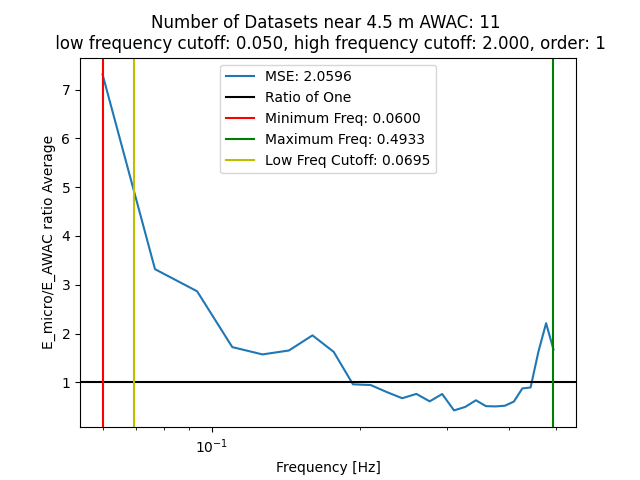

In [85]:
# Apply the optimal filter to all of the datasets
mse_uncorrected, E_ratio_avg_uncorrected, f_ratio_avg_uncorrected = applyFilter([0.05, 2, 1] , nearAWAC_data_subset, awac_time, awac_data)

# Plot the ratio with the optimal filter
fig_optimal, ax = plt.subplots()
ax.semilogx(f_ratio_avg_uncorrected, E_ratio_avg_uncorrected, label='MSE: {0:.4f}'.format(mse_uncorrected))
ax.axhline(1, color='k', label='Ratio of One')
ax.axvline(f_ratio_avg_uncorrected[0], color='r', label='Minimum Freq: {0:.4f}'.format(f_ratio_avg_uncorrected[0]))
ax.axvline(f_ratio_avg_uncorrected[-1], color='g', label='Maximum Freq: {0:.4f}'.format(f_ratio_avg_uncorrected[-1]))
ax.axvline(res.x[0], color='y', label='Low Freq Cutoff: {0:.4f}'.format(res.x[0]))
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('E_micro/E_AWAC ratio Average')
# ax.set_title('Number of Datasets near 4.5 m AWAC: {0} \n low frequency cutoff: {1:.3f}, high frequency cutoff: {2:.3f}, order: {3}'.format(len(nearAWAC_data_subset), res.x[0], res.x[1], int(res.x[2])))
ax.set_title('Number of Datasets near 4.5 m AWAC: {0} \n low frequency cutoff: {1:.3f}, high frequency cutoff: {2:.3f}, order: {3}'.format(len(nearAWAC_data_subset), 0.05, 2, int(1)))


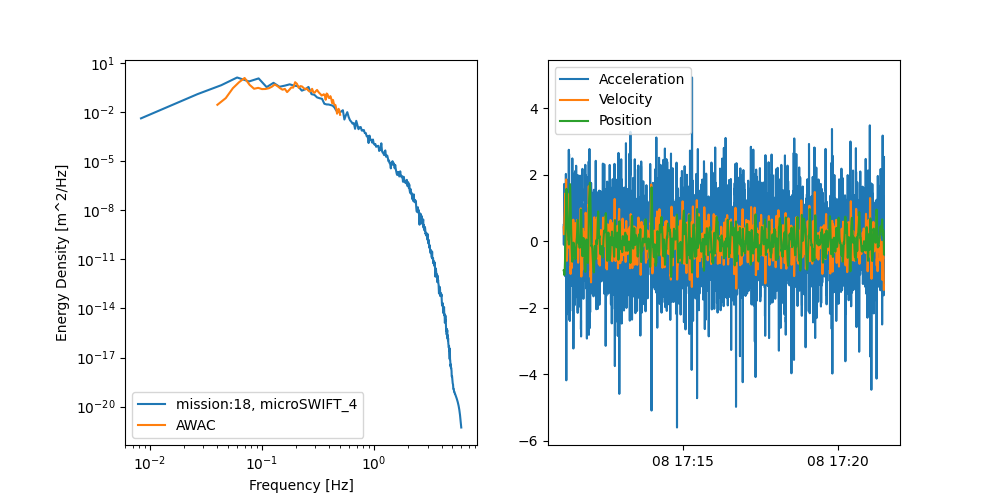

In [86]:
# Plot all spectra
n = 4
fig_spectra, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.loglog(nearAWAC_data_subset[n].f_bandavg, nearAWAC_data_subset[n].E_bandavg, label='mission:{}, {}'.format(nearAWAC_data_subset[n].mission_num[-5:-3], nearAWAC_data_subset[n].microSWIFT_num))
ax1.loglog(nearAWAC_data_subset[n].f_awac, nearAWAC_data_subset[n].E_awac, label='AWAC')
ax1.legend()
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Energy Density [m^2/Hz]')

ax2.plot(nearAWAC_data_subset[n].time_filt, nearAWAC_data_subset[n].a_z_filt, label='Acceleration')
ax2.plot(nearAWAC_data_subset[n].time_filt, nearAWAC_data_subset[n].w, label='Velocity')
ax2.plot(nearAWAC_data_subset[n].time_filt, nearAWAC_data_subset[n].z, label='Position')
ax2.legend()


In [87]:
# fig_Hs, ax = plt.subplots()
for dataset in nearAWAC_data_subset:
    # Compute Hs
    micro_Hs = 4 * np.std(dataset.z)
    print('Micro Hs: {}'.format(micro_Hs))
    print('AWAC Hs: {}'.format(dataset.Hs_awac))


Micro Hs: 1.7889770043986963
AWAC Hs: 1.2444472312927246
Micro Hs: 1.8225915772476269
AWAC Hs: 1.271523356437683
Micro Hs: 1.6720779167705686
AWAC Hs: 1.271523356437683
Micro Hs: 1.4587101350385423
AWAC Hs: 1.271523356437683
Micro Hs: 1.6030434168050123
AWAC Hs: 1.271523356437683
Micro Hs: 1.7380147035434002
AWAC Hs: 1.271523356437683
Micro Hs: 1.6203748124260249
AWAC Hs: 1.313481092453003
Micro Hs: 1.6523395355599841
AWAC Hs: 1.2687804698944092
Micro Hs: 1.6581436990067835
AWAC Hs: 1.5081857442855835
Micro Hs: 2.073198600348735
AWAC Hs: 2.125196695327759
Micro Hs: 2.4606456489350186
AWAC Hs: 1.199378490447998


Text(0.5, 1.0, 'Number of Datasets near 4.5 m AWAC: 11 \n low frequency cutoff: 0.069, high frequency cutoff: 1.151, order: 1')

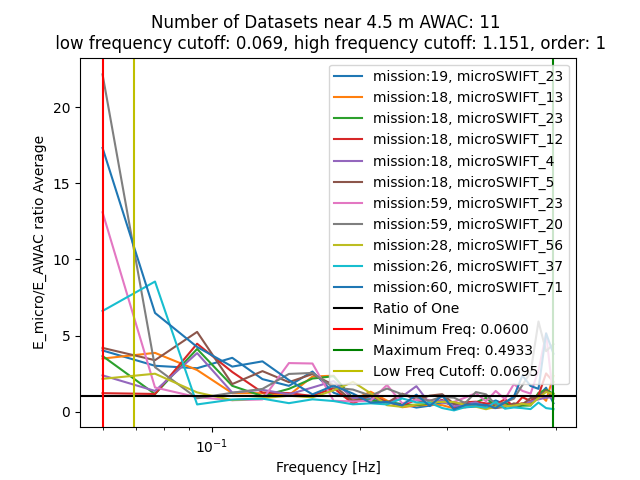

In [88]:
# Plot all Ratios of Spectra
fig_spec_ratio, ax = plt.subplots()
for n in np.arange(len(nearAWAC_data_subset)):
    ax.semilogx(nearAWAC_data_subset[n].f_waves, nearAWAC_data_subset[n].E_ratio, label='mission:{}, {}'.format(nearAWAC_data_subset[n].mission_num[-5:-3], nearAWAC_data_subset[n].microSWIFT_num))

ax.axhline(1, color='k', label='Ratio of One')
ax.axvline(f_ratio_avg_uncorrected[0], color='r', label='Minimum Freq: {0:.4f}'.format(f_ratio_avg_uncorrected[0]))
ax.axvline(f_ratio_avg_uncorrected[-1], color='g', label='Maximum Freq: {0:.4f}'.format(f_ratio_avg_uncorrected[-1]))
ax.axvline(res.x[0], color='y', label='Low Freq Cutoff: {0:.4f}'.format(res.x[0]))
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('E_micro/E_AWAC ratio Average')
ax.set_title('Number of Datasets near 4.5 m AWAC: {0} \n low frequency cutoff: {1:.3f}, high frequency cutoff: {2:.3f}, order: {3}'.format(len(nearAWAC_data_subset), res.x[0], res.x[1], int(res.x[2])))


In [89]:
# # Apply filters to the AHRS corrected data
# nearAWAC_subset_ahrs = []
# for n in np.arange(len(nearAWAC_data_subset)):
#     nearAWAC_subset_ahrs.append(nearAWAC_data_subset[n])
#     print(nearAWAC_subset_ahrs[n].mission_num)
#     print(nearAWAC_subset_ahrs[n].microSWIFT_num)

# def overwriteAccel(nearAWACData, ahrs_fname):
#     ahrs_data = io.loadmat(ahrs_fname)
#     nearAWACData.a_z = np.squeeze(ahrs_data['az_corrected'])
#     return

# # overwrite the acceleration values with the new corrected values
# # mission 19, microSWIFT 23
# overwriteAccel(nearAWAC_subset_ahrs[0], 'ahrs_mission19_microSWIFT_23.mat')

# # mission 18, microSWIFT 13 
# overwriteAccel(nearAWAC_subset_ahrs[1], 'ahrs_mission18_microSWIFT_13.mat')

# # mission 18, microSWIFT 23 
# overwriteAccel(nearAWAC_subset_ahrs[2], 'ahrs_mission18_microSWIFT_23.mat')

# # mission 18, microSWIFT 12
# overwriteAccel(nearAWAC_subset_ahrs[3], 'ahrs_mission18_microSWIFT_12.mat')

# # mission 18, microSWIFT 4
# overwriteAccel(nearAWAC_subset_ahrs[4], 'ahrs_mission18_microSWIFT_4.mat')

# # mission 18, microSWIFT 5
# overwriteAccel(nearAWAC_subset_ahrs[5], 'ahrs_mission18_microSWIFT_5.mat')

# # mission 59, microSWIFT 23
# overwriteAccel(nearAWAC_subset_ahrs[6], 'ahrs_mission59_microSWIFT_23.mat')

# # mission 59, microSWIFT 20
# overwriteAccel(nearAWAC_subset_ahrs[7], 'ahrs_mission59_microSWIFT_20.mat')

# # mission 28, microSWIFT 56
# overwriteAccel(nearAWAC_subset_ahrs[8], 'ahrs_mission28_microSWIFT_56.mat')

# # mission 26, microSWIFT 37
# overwriteAccel(nearAWAC_subset_ahrs[9], 'ahrs_mission26_microSWIFT_37.mat')

# # mission 60, microSWIFT 71
# overwriteAccel(nearAWAC_subset_ahrs[10], 'ahrs_mission60_microSWIFT_71.mat')

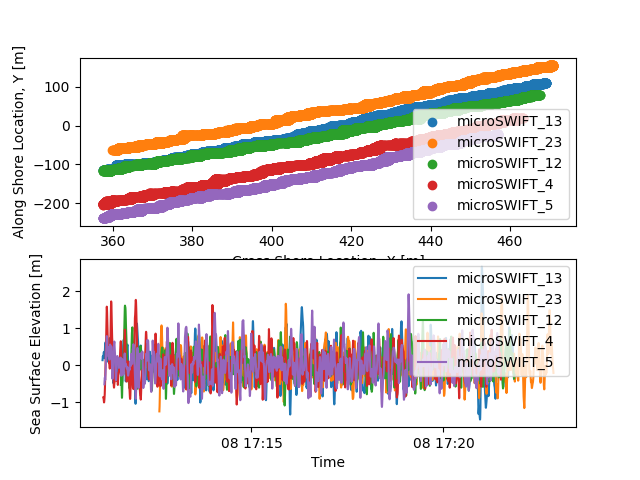

In [90]:
# Plot elevation of nearby buoys 
fig_eta_comp, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(nearAWAC_subset_ahrs[1].x, nearAWAC_subset_ahrs[1].y, label=nearAWAC_subset_ahrs[1].microSWIFT_num)
ax1.scatter(nearAWAC_subset_ahrs[2].x, nearAWAC_subset_ahrs[2].y, label=nearAWAC_subset_ahrs[2].microSWIFT_num)
ax1.scatter(nearAWAC_subset_ahrs[3].x, nearAWAC_subset_ahrs[3].y, label=nearAWAC_subset_ahrs[3].microSWIFT_num)
ax1.scatter(nearAWAC_subset_ahrs[4].x, nearAWAC_subset_ahrs[4].y, label=nearAWAC_subset_ahrs[4].microSWIFT_num)
ax1.scatter(nearAWAC_subset_ahrs[5].x, nearAWAC_subset_ahrs[5].y, label=nearAWAC_subset_ahrs[5].microSWIFT_num)
ax1.set_xlabel('Cross Shore Location, X [m]')
ax1.set_ylabel('Along Shore Location, Y [m]')
ax1.legend()

ax2.plot(nearAWAC_subset_ahrs[1].time_filt, nearAWAC_subset_ahrs[1].z, label=nearAWAC_subset_ahrs[1].microSWIFT_num)
ax2.plot(nearAWAC_subset_ahrs[2].time_filt, nearAWAC_subset_ahrs[2].z, label=nearAWAC_subset_ahrs[2].microSWIFT_num)
ax2.plot(nearAWAC_subset_ahrs[3].time_filt, nearAWAC_subset_ahrs[3].z, label=nearAWAC_subset_ahrs[3].microSWIFT_num)
ax2.plot(nearAWAC_subset_ahrs[4].time_filt, nearAWAC_subset_ahrs[4].z, label=nearAWAC_subset_ahrs[4].microSWIFT_num)
ax2.plot(nearAWAC_subset_ahrs[5].time_filt, nearAWAC_subset_ahrs[5].z, label=nearAWAC_subset_ahrs[5].microSWIFT_num)
ax2.set_xlabel('Time')
ax2.set_ylabel('Sea Surface Elevation [m]')
ax2.legend()



(7925,)


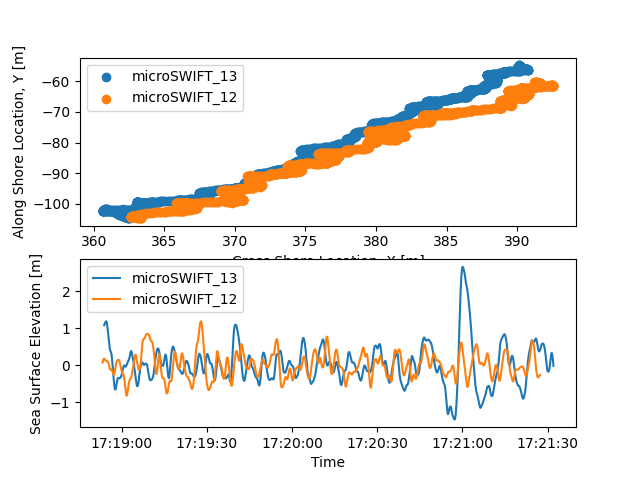

In [91]:
# Plot elevation of nearby buoys 
inds1 = slice(5600, 7500)
inds3 = slice(5250, 7100)

fig_eta_comp, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(nearAWAC_subset_ahrs[1].x[inds1], nearAWAC_subset_ahrs[1].y[inds1], label=nearAWAC_subset_ahrs[1].microSWIFT_num)
ax1.scatter(nearAWAC_subset_ahrs[3].x[inds3], nearAWAC_subset_ahrs[3].y[inds3], label=nearAWAC_subset_ahrs[3].microSWIFT_num)
ax1.set_xlabel('Cross Shore Location, X [m]')
ax1.set_ylabel('Along Shore Location, Y [m]')
ax1.legend()

ax2.plot(nearAWAC_subset_ahrs[1].time_filt[inds1], nearAWAC_subset_ahrs[1].z[inds1], label=nearAWAC_subset_ahrs[1].microSWIFT_num)
ax2.plot(nearAWAC_subset_ahrs[3].time_filt[inds3], nearAWAC_subset_ahrs[3].z[inds3], label=nearAWAC_subset_ahrs[3].microSWIFT_num)
ax2.set_xlabel('Time')
ax2.set_ylabel('Sea Surface Elevation [m]')
ax2.legend()
print(nearAWAC_subset_ahrs[1].x.shape)